In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [2]:
import os

# Replace 'your/folder/path' with the path to the directory you want to use
path = '/content/drive/MyDrive/CKAN-drive'
os.chdir(path)

# Now the current directory is set to 'your/folder/path'
print("Current Working Directory is changed to:", os.getcwd())

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/CKAN-drive'

In [1]:
# Setup
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image
import spline
from utils import try_gpu, compute_min_max
from torch.utils.data import TensorDataset, DataLoader
import os
from torchvision.datasets import MNIST
import time
import torch.nn.functional as F


In [2]:
# Main implementation of CKANLayer
class CKANLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, grid, stride=1, padding=0, degree=3, grid_range=[-1, 1], device='cuda:0'):
        super(CKANLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.size = size = in_channels * kernel_size ** 2

        self.stride = stride
        self.padding = padding
        self.degree = degree
        self.grid = grid
        self.grid_range = grid_range
        self.device = device
        self.cache = None
        self.grid

        # Initialize knots and coefficients on the right device during creation
        # knots shape - (size, grid + 1)
        knots = torch \
            .linspace(grid_range[0], grid_range[1], steps=grid + 1, device=device) \
            .view(1, -1) \
            .repeat(size, 1)
        self.knots = nn.Parameter(knots, requires_grad=False)

        # coeff shape - (out_channels, size, grid + degree)
        self.coeff = nn.Parameter(0.1 * torch.randn(out_channels, size, grid + degree, device=device), requires_grad=True)
        
        # Initialize the using Xavier method, as specified in paper
        self.base_weights = torch.nn.Parameter(torch.Tensor(out_channels, size), requires_grad=True)
        nn.init.xavier_uniform_(self.base_weights)  # Xavier uniform initialization
        
        # Initialize with ones, as specified in paper
        self.spline_weights = torch.nn.Parameter(torch.ones(out_channels, size), requires_grad=True)



    def forward(self, x):
        N, _, H, W = x.shape
        x_padded = F.pad(x, [self.padding, self.padding, self.padding, self.padding])

        # Unfold to get all sliding windows - Shape becomes  (N, C*K*K, L) where L is the number of extracted windows
        unfolded = F.unfold(x_padded, kernel_size=self.kernel_size, stride=self.stride, padding=0).reshape(self.size, -1)

        # unfolded.transpose(1, 2).reshape(N, -1, self.in_channels, self.kernel_size, self.kernel_size)
        # # Prepare unfolded for batch processing in coef2curve - Final shape becomes (C*K*K, N * L)
        # unfolded = unfolded.reshape(self.size, -1)

        # store the input for later
        self.cache = unfolded

        # Output tensor initialization
        Hp = (H + 2 * self.padding - self.kernel_size) // self.stride + 1
        Wp = (W + 2 * self.padding - self.kernel_size) // self.stride + 1
        output = torch.zeros((self.out_channels, N, Hp, Wp), device=self.device)

        # Loop through each output channel
        for c in range(self.out_channels):
            # This calculates w_b*b(x) - Output shape - (1, N * L)
            base_values = F.linear(F.silu(unfolded).t(), self.base_weights[c])

            # This calculates w_s*spline(x) - Output shape - (1, N * L). Instead of summing the spline values as before, we use (C*K*K, 1) dimensional weights
            spline_values = F.linear(spline.coef2curve(unfolded, self.knots, self.coeff[c], self.degree, device=self.device).t(), self.spline_weights[c])

            res_values = base_values + spline_values 
            output[c] = res_values.view(N, Hp, Wp)
        
        return output.transpose(0, 1)
    

    def update_grid(self, new_grid):
        new_knots = torch \
            .linspace(self.grid_range[0], self.grid_range[1], steps=new_grid + 1, device=self.device) \
            .view(1, -1) \
            .repeat(self.size, 1)
        
        new_coeffs_data = torch.zeros(self.out_channels, self.size, new_grid + self.degree, device=self.device)

        for i in range(self.out_channels):
            # x = self.cache if self.cache is not None else torch.zeros(self.size, 1)
            # as recommended, use the grid points to calculate the new coefficients because they are evenely spaced
            x = new_knots
            y = spline.coef2curve(x, self.knots, self.coeff[i], self.degree)

            new_coeffs_data[i] = spline.curve2coef(x, y, new_knots, self.degree)

        # Update the grid points for the spline
        self.grid = new_grid

        self.coeff = nn.Parameter(new_coeffs_data, requires_grad=True)
        self.knots = nn.Parameter(new_knots, requires_grad=False)



    def update_grid_from_samples(self, x):
        '''
        update grid from samples
        
        Args:
        -----
            x : 2D torch.float
                inputs, shape (number of samples, input dimension)
            
        Returns:
        --------
            None
        '''
        batch = x.shape[0]
        x = torch.einsum('ij,k->ikj', x, torch.ones(self.out_dim, ).to(self.device)).reshape(batch, self.size).permute(1, 0)
        x_pos = torch.sort(x, dim=1)[0]
        y_eval = spline.coef2curve(x_pos, self.grid, self.coef, self.k, device=self.device)
        num_interval = self.grid.shape[1] - 1
        ids = [int(batch / num_interval * i) for i in range(num_interval)] + [-1]
        grid_adaptive = x_pos[:, ids]
        margin = 0.01
        grid_uniform = torch.cat([grid_adaptive[:, [0]] - margin + (grid_adaptive[:, [-1]] - grid_adaptive[:, [0]] + 2 * margin) * a for a in np.linspace(0, 1, num=self.grid.shape[1])], dim=1)
        self.grid.data = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        self.coef.data = spline.curve2coef(x_pos, y_eval, self.grid, self.k, device=self.device)

In [3]:

# CNN architecture
class CNNNet(nn.Module):
  def __init__(self, in_channels, hidden_channels, out_features, device='cuda:0'):
          super(CNNNet, self).__init__()

          self.conv1 =  nn.Conv2d(in_channels, hidden_channels[0],
                                 kernel_size=3,
                                 padding=1)

          self.conv2 =  nn.Conv2d(hidden_channels[0], hidden_channels[1],
                          kernel_size=3,
                          padding=1)
          self.relu = nn.ReLU()
          self.max_pool = nn.MaxPool2d(2)

          self.linear1 = nn.Linear(245, out_features)

  def forward(self, x):
      # First convolutional layer
      x = self.relu(self.conv1(x))
      x = self.max_pool(x)
      x = self.relu(self.conv2(x))
      x = self.max_pool(x)
      x = x.view(x.size(0), -1)
      x = self.linear1(x)
      return x

# CKAN architecture
class CKANNet(nn.Module):
  def __init__(self, in_channels, hidden_channels, out_features, grid, device='cuda:0'):
          super(CKANNet, self).__init__()

        #   self.depth = 

          self.conv1 = CKANLayer(in_channels, hidden_channels[0],
                                  kernel_size=3,
                                  padding=1, grid=grid, device=device)

          self.conv2 = CKANLayer(hidden_channels[0], hidden_channels[1],
                                kernel_size=3,
                                padding=1, grid=grid, device=device)
          # self.relu = nn.ReLU()
          self.max_pool = nn.MaxPool2d(2)
          self.linear1 = nn.Linear(245, out_features)

  def forward(self, x):
      # First convolutional layer
      x = self.conv1(x)
      x = self.max_pool(x)
      # print(x[0][0])
      x = self.conv2(x)
      x = self.max_pool(x)
      x = x.view(x.size(0), -1)
      x = self.linear1(x)
      return x
  
  def update_grid(self, grid):
       self.conv1.update_grid(grid)
       self.conv2.update_grid(grid)


### For experiments on MNIST, please don't use this file, refer to [this file](experiments/MNIST_CKAN.ipynb)

In [4]:
from torch.utils.data import Subset

# Transformaciones
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Cargar MNIST y filtrar por dos clases
mnist_train = MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Define a function to create a subset of the dataset
def get_subset(dataset, fraction):
    subset_size = int(len(dataset) * fraction)
    indices = torch.randperm(len(dataset))[:subset_size]
    return Subset(dataset, indices)

# Create subsets with only X% of the data
# This speeds up training immensely
fraction = 0.001
train_val_dataset = get_subset(mnist_train, fraction)
test_dataset = get_subset(mnist_test, fraction)

# DataLoader
BATCH_SIZE = 256
train_loader = DataLoader(train_val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
def evaluate_accuracy(data_loader, net, device=torch.device('cuda:0')):
    """Evaluate accuracy of a model on the given data set."""
    net.eval()  #make sure network is in evaluation mode

    #init
    acc_sum = torch.tensor([0], dtype=torch.float32, device=device)
    n = 0

    for X, y in data_loader:
        # Copy the data to device.
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y = y.long()
            acc_sum += torch.sum((torch.argmax(net(X), dim=1) == y))
            n += y.shape[0] #increases with the number of samples in the batch
    return acc_sum.item()/n

In [9]:
in_channels = 1 # Black-white images in MNIST digits
hidden_channels = [5, 5]
out_features = 10

# Training parameters
learning_rate = 0.0035
num_epochs = 5

min_grid = 1
max_grid, curr_grid = 11, min_grid
grid_range = compute_min_max(train_val_dataset)

step = 4
grid_update_freq = int(num_epochs / ((max_grid - min_grid) / step + 1e-5))
print('grid_update_freq: ', grid_update_freq)

# Try using gpu instead of cpu
device = try_gpu()

# Uncomment other line if you want to test plain CNN
net = CKANNet(in_channels, hidden_channels, out_features, grid=min_grid, device=device).to(device)
net.conv1.grid_range = grid_range
net.conv2.grid_range = grid_range
# net = CNNNet(in_channels, hidden_channels, out_features, device=device).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Define list to store losses and performances of each iteration
train_losses = []
train_accs = []
test_accs = []

epoch_times = []
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    # Cannot get grid extension to work with current CKAN setup :-(
    if (epoch + 1) % grid_update_freq == 0 and curr_grid < max_grid and epoch > 0:
        curr_grid += step
        print(f"Updating grid to {curr_grid} in epoch {epoch+1}")
        net.update_grid(curr_grid)
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # Network in training mode and to device
    net.train()
    # print(net.conv1.coeff)

    # Training loop
    for x_batch, y_batch in train_loader:
        # Set to same device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = net(x_batch)

        loss = criterion(y_pred, y_batch)
        train_losses.append(loss)

        loss.backward()
        optimizer.step()

    # Compute train and test error
    train_acc = 100 * evaluate_accuracy(train_loader, net.to(device), device)
    test_acc = 100 * evaluate_accuracy(test_loader, net.to(device), device)

    # Development of performance
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # Print performance
    print(f'Epoch: {epoch+1}')
    print('Accuracy of train set: {:.1f}%'.format(train_acc))
    print('Accuracy of test set: {:.1f}%'.format(test_acc))
    print('')

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_times.append(epoch_duration)


total_time = time.time() - start_time
avg_epoch_time = np.mean(epoch_times)

print(f"Total training time: {total_time:.2f} seconds")
print(f"Average time per epoch: {avg_epoch_time:.2f} seconds")

grid_update_freq:  1
Epoch: 1
Accuracy of train set: 10.0%
Accuracy of test set: 10.0%

Updating grid to 5 in epoch 2
Epoch: 2
Accuracy of train set: 13.3%
Accuracy of test set: 10.0%

Updating grid to 9 in epoch 3
Epoch: 3
Accuracy of train set: 16.7%
Accuracy of test set: 10.0%

Updating grid to 13 in epoch 4
Epoch: 4
Accuracy of train set: 16.7%
Accuracy of test set: 20.0%

Epoch: 5
Accuracy of train set: 20.0%
Accuracy of test set: 10.0%

Total training time: 19.35 seconds
Average time per epoch: 3.87 seconds


In [7]:
print(torch.cuda.is_available())


False


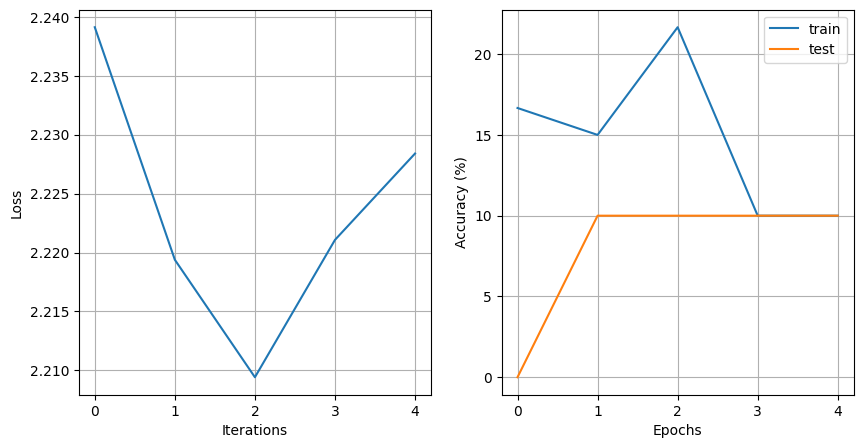

In [8]:
import matplotlib.pyplot as plt

# Assuming 'train_losses' is a list of tensors
train_losses_detached = [loss.detach().cpu().numpy() for loss in train_losses]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(train_losses_detached)  # Use the detached list of numpy arrays
plt.grid()

# Assuming you have additional plots or other code to follow
plt.subplot(1, 2, 2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.plot(train_accs, label = 'train')
plt.plot(test_accs, label = 'test')
plt.legend()
plt.grid()
